<a href="https://colab.research.google.com/github/yeha98555/data-course-sample/blob/main/S5/A6_cf-used-based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# User-based collaborative filtering

## 基礎建設

In [ ]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2022-01-09 06:47:48--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv’

All_Beauty.csv      100%[===================>]  14.78M  19.1MB/s    in 0.8s    

2022-01-09 06:47:49 (19.1 MB/s) - ‘All_Beauty.csv’ saved [15499476/15499476]

--2022-01-09 06:47:49--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz’

meta_All_Beauty.jso 100%[===================>]   9.85M  14.0MB/s    in 0.7s    

202

In [ ]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [ ]:
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [ ]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


## 資料整理

In [ ]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

### 去除重複資料

#### metadata（資料完全一樣的商品）

In [ ]:
print('Original Num of metadata: {0}'.format(len(metadata)))
print('Num of duplicated metadata: {0}'.format(metadata.duplicated(subset=['asin', 'title']).sum()))

print('Drop duplicated metadata...')
metadata.drop_duplicates(subset=['asin', 'title'], keep=False, inplace=True)
metadata = metadata.reset_index(drop=True)
print('Current Num of metadata: {0}'.format(len(metadata)))

Original Num of metadata: 32892
Num of duplicated metadata: 404
Drop duplicated metadata...
Current Num of metadata: 32084


#### ratings
重複評分，將在資料探索時處理。

## 資料切分

In [ ]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

---

保留原始資料，複製一份出來處理。

In [ ]:
metadata_tmp = metadata.copy()

ratings_trainings_tmp = ratings_trainings.copy()
ratings_testings_tmp = ratings_testings.copy()

users_testing_tmp = users.copy()

---

## 資料探索

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

### 測試資料集

查看測試資料集中的用戶有多少人曾經留下評分過？各留下多少呢？

In [ ]:
num_rating_user = ratings_trainings_tmp[ratings_trainings_tmp['reviewerID'].isin(users_testing_tmp)]['reviewerID'].nunique()
print('多少人曾留過評分 : {0} ({1}%)'.format(num_rating_user, round(num_rating_user / len(users_testing_tmp)*100)))

多少人曾留過評分 : 38 (7%)


In [ ]:
print(ratings_trainings_tmp[ratings_trainings_tmp['reviewerID'].isin(users_testing_tmp)].groupby('reviewerID').agg({'asin':'size'}))
print('這些人平均對多少商品評分: {0}'.format(ratings_trainings_tmp[ratings_trainings_tmp['reviewerID'].isin(users_testing_tmp)].groupby('reviewerID').agg({'asin':'size'}).mean()[0]))

                asin
reviewerID          
A13JU88JAHN72I     1
A16Y7V1CZCWKFV     1
A19503XX7GU6J2     2
A1EY751AUVO5NZ     1
A1PR178735XC70     1
A1SA3N793WT2LM     4
A1TP9JHTIY468V     2
A1UAOE8KO7Q1DZ     1
A1WEFBEJ7OHSVZ     1
A1WSZED2O5MA5T     2
A28E3FNV1BYC94     1
A29834GBB4DOP1     1
A2AAQWBJJTK3E1     1
A2BU6N5956T9NH     1
A2GFPTQ4VWDX96     1
A2IMJV0CQMZLGC     1
A2IOBG1ERS4JP3     1
A2JCBLTLYDPQLW     1
A2M4YSOJZELJ6N     1
A2XFJ8CTY7VDNN     1
A2XY3CJ3ZCAD03     1
A3BE6JK97CYAGA     1
A3BT1WLPENXMD6     3
A3DXW3542E4QUC     1
A3GRQ9WMP4OXFE     1
A3H8Z7JS7XJHJJ     2
A3JEQJCEMX20GI     2
A4IQXCCXDEAKW      2
A7JUHUYLXIUVQ      1
A7Y4ETTLARUGI      1
ACE1ZIOI3U6PY      3
AGRZQOBCF8H87      1
AITF34BGBMVJJ      1
AK7YIZE6ZZ1N9      1
ANR73TPVBCQ9K      1
AQYL4TDY2HU8Z      1
ASGIVOW34XNQS      3
ATJRZUXNWAWIK      1
這些人平均對多少商品評分: 1.394736842105263


如果未曾留下評分，則無法得知喜好，也無法找過去購買的商品推薦類似的，只能用rule-based。<br>
發現有留過評分的占少數，故rule-based方法對整體推薦系統recall影響大。

### 訓練資料集

#### 是否有不同日重複評分？

In [ ]:
ratings_trainings_tmp.groupby(['reviewerID', 'asin'])['DATE'].nunique().describe()

count    361012.000000
mean          1.001651
std           0.044442
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           7.000000
Name: DATE, dtype: float64

發現有重複評分，甚至有一用戶對同商品評分達6次。

找出重複的部分。

In [ ]:
duplicate = ratings_trainings_tmp[ratings_trainings_tmp.duplicated(subset=['reviewerID', 'asin'], keep=False)]
duplicate.head()

,asin,reviewerID,overall,unixReviewTime,DATE
2352,1620213982,AD80MGOY5CJZ4,5.0,1451692800,2016-01-02
4017,1620213982,AD80MGOY5CJZ4,5.0,1422662400,2015-01-31
6904,B000052YAN,ACTVXNBEPLW2S,4.0,1422144000,2015-01-25
6905,B000052YAN,ACTVXNBEPLW2S,4.0,1422144000,2015-01-25
6941,B0000530HU,A2CTM1BYAXTYLX,5.0,1243987200,2009-06-03


In [ ]:
print('總評分筆數: {0}'.format(len(ratings_trainings_tmp)))
print('總重複筆數: {0}'.format(len(duplicate)))

總評分筆數: 370752
總重複筆數: 19218


在想重複評分要用平均數還是用最近評分，用平均思考的是因為可能同商品出貨品質不一定而導致評分不同，用最近則思考有可能同商品但近期品質有改變。認為是後面能分別測試看看的。

In [ ]:
# 如果只有一筆就直接填該筆評分，如果有多筆，overall_mean填入評分平均值、overall_lastest填入最近的評分值。
ratings_trainings_unique = ratings_trainings_tmp.groupby(['reviewerID', 'asin']) \
                    .agg(overall_lastest=('overall', lambda x: list(x)[0]), overall_mean=('overall', np.mean)) \
                    .reset_index()
ratings_trainings_unique.head()

,reviewerID,asin,overall_lastest,overall_mean
0,A0010876CNE3ILIM9HV0,B01FHDYGQ8,5.0,5.0
1,A001170867ZBE9FORRQL,B01B18T01Y,5.0,5.0
2,A001170867ZBE9FORRQL,B01FCW88D6,5.0,5.0
3,A0028738FYF1SKPPC7B1,B00TZ8XK1E,5.0,5.0
4,A0045356A23634W7RI4M,B018H0EJI8,3.0,3.0


In [ ]:
print('重複合併後，總評分筆數: {0}'.format(len(ratings_trainings_unique)))

重複合併後，總評分筆數: 361012


#### 用戶有多少曾經留下評分過？

In [ ]:
ratings_trainings_user = ratings_trainings_unique.groupby('reviewerID') \
       .agg({'asin':'size', 'overall_mean':'mean'}) \
       .rename(columns={'asin':'asin_count','overall':'mean_score'}) \
       .reset_index().sort_values('asin_count', ascending=False)
ratings_trainings_user.head()

,reviewerID,asin_count,overall_mean
124969,A2GJX2KCUSR0EI,24,4.479167
49192,A1KSC91G9AIY2Z,22,3.000000
272887,AENH50GW3OKDA,20,4.550000
91223,A22CW0ZHY3NJH8,18,4.231481
72941,A1UQBFCERIP7VJ,16,4.625000


In [ ]:
print('多少人曾留過評分 : {0} ({1}%)'.format(len(ratings_trainings_user), round(len(ratings_trainings_user)/len(ratings_trainings_tmp.groupby('reviewerID').nunique())*100)))

多少人曾留過評分 : 323489 (100%)


In [ ]:
print(ratings_trainings_user['asin_count'])
print('這些人平均對多少商品評分 {0}'.format(ratings_trainings_user['asin_count'].mean()))

124969    24
49192     22
272887    20
91223     18
72941     16
          ..
112944     1
112943     1
112941     1
112940     1
161744     1
Name: asin_count, Length: 323489, dtype: int64
這些人平均對多少商品評分 1.1159946706070376


但認為只有評分過一個商品的用戶沒有用，因為由該商品找到與用戶相似後，就無能推薦的商品，故移除該用戶。

In [ ]:
ratings_trainings_user = ratings_trainings_user[ratings_trainings_user['asin_count'] > 1]
print('移除只有評分過一個商品的用戶，剩下剩下 {0} ({1}%)'.format(len(ratings_trainings_user), round(len(ratings_trainings_user)/len(ratings_trainings_tmp.groupby('reviewerID').nunique())*100)))

移除只有評分過一個商品的用戶，剩下剩下 29605 (9%)


In [ ]:
print(ratings_trainings_user['asin_count'])
print('這些人平均對多少商品評分 {0}'.format(ratings_trainings_user['asin_count'].mean()))

124969    24
49192     22
272887    20
91223     18
72941     16
          ..
81202      2
181989     2
102424     2
167306     2
94223      2
Name: asin_count, Length: 29605, dtype: int64
這些人平均對多少商品評分 2.2674548218206385


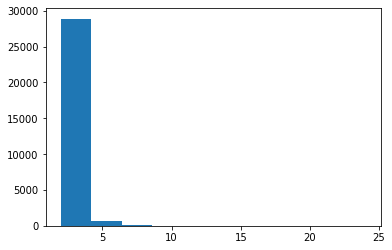

將評分商品數超過5個的放大來看...


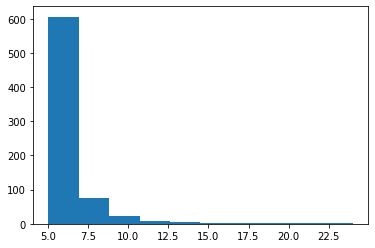

將評分商品數超過10個的放大來看...


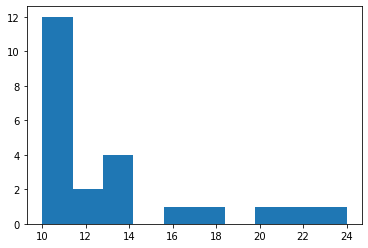

In [ ]:
plt.hist(ratings_trainings_user['asin_count'])
plt.show()
print('將評分商品數超過5個的放大來看...')
plt.hist(ratings_trainings_user[ratings_trainings_user['asin_count'] > 4]['asin_count'])
plt.show()
print('將評分商品數超過10個的放大來看...')
plt.hist(ratings_trainings_user[ratings_trainings_user['asin_count'] > 9]['asin_count'])
plt.show()

發現大多用戶評分的商品數只有5個以下。
也思考多少個商品評分才能夠代表一個人的購買喜好？認為可留到之後測試。

### 商品資料

根據上份作業的資料探索，將多餘欄位剔除，新增有意義欄位(商品評論數、平均評分、季節性等)。主要是想用於找不到相似用戶時的推薦設計使用。

在此的ratings_trainings都不剔除重複評分，視其各自為獨立購買紀錄，皆列入分析計算。

In [ ]:
# 剔除有問題的資料
metadata_tmp = metadata_tmp.drop(metadata[metadata['title'] == ''].index).reset_index(drop=True)

#### 剔除多餘欄位

In [ ]:
metadata_tmp = metadata_tmp.drop(['category', 'tech1', 'fit', 'tech2', 'feature', 'date', 'imageURLHighRes', 'main_cat', 'details'], axis=1)

##### `rank`: 內含有商品類別和其商品於該類別排名，將其拆成`RANK`、`CATEGORY`兩欄位。

In [ ]:
metadata_tmp[['RANK', 'CATEGORY']] = metadata_tmp['rank'].str.split(' in ', 1, expand=True)
metadata_tmp['CATEGORY'] = metadata_tmp['CATEGORY'].str.replace(' \(', '')
metadata_tmp['CATEGORY'] = metadata_tmp['CATEGORY'].str.replace('\&amp;', '&')
metadata_tmp['CATEGORY'].value_counts()

Beauty & Personal Care       31650
Grocery & Gourmet Food          36
Health & Household              21
Sports & Outdoors                3
Toys & Games                     3
Baby                             2
Clothing, Shoes & Jewelry        2
Tools & Home Improvement         1
Automotive                       1
Home & Kitchen                   1
Name: CATEGORY, dtype: int64

In [ ]:
metadata_tmp = metadata_tmp.drop(['rank'], axis=1)

##### `similar_item`: 將其資料html表格轉為asin列表，與`also_buy`、`also_view`合併成`SIMILAR_ITEM`欄位。

In [ ]:
from bs4 import BeautifulSoup
metadata['asin'] = metadata['asin'].astype(str)

def convert_similar_table_to_asin_list(html):
#     if (html == ''): return []
    asin_list = []
    
    soup = BeautifulSoup(html)
    
    compare_list = soup.findAll('th', {'class': 'comparison_image_title_cell'})
    for item in compare_list:
        title = item.span.text.strip()
        if (len(metadata[metadata['title'] == title]) > 0):
            asin = metadata[metadata['title'] == title]['asin'].iloc[0]
#             if (not any(asin.str in s for s in asin_list)):  # 去除重複
            asin_list.append(asin)
    
    return asin_list

In [ ]:
metadata_tmp['SIMILAR_ITEM'] = metadata_tmp['similar_item'].apply(lambda x: convert_similar_table_to_asin_list(x) if x != ''  else x)

In [ ]:
metadata_tmp['SIMILAR'] = [set(list(x)+y+z) for x, y, z in zip(metadata_tmp.SIMILAR_ITEM, metadata_tmp.also_view, metadata_tmp.also_buy)]

In [ ]:
metadata_tmp = metadata_tmp.drop(['SIMILAR_ITEM', 'similar_item', 'also_view', 'also_buy'], axis=1)

In [ ]:
metadata_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32083 entries, 0 to 32082
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  32083 non-null  object
 1   title        32083 non-null  object
 2   brand        32083 non-null  object
 3   price        32083 non-null  object
 4   asin         32083 non-null  object
 5   imageURL     32083 non-null  object
 6   RANK         31720 non-null  object
 7   CATEGORY     31720 non-null  object
 8   SIMILAR      32083 non-null  object
dtypes: object(9)
memory usage: 2.2+ MB


#### 加入評分
(同用戶對同商品不同時間或不同評分，做為獨立評分(未合併)，分別計入)

In [ ]:
rating_mean = ratings_trainings_tmp.groupby('asin')['overall'].mean().round(2).reset_index(name='RATE')
rating_count = pd.DataFrame(ratings_trainings_tmp.asin.value_counts())
rating_count.reset_index(inplace=True)
rating_count.columns = ['asin', 'RATE(COUNT)']
# merge
rating_data = rating_mean.merge(rating_count, on='asin')
metadata_tmp = pd.merge(rating_data, metadata_tmp, left_on="asin", right_on="asin", how='right')

In [ ]:
metadata_tmp.fillna({'RATE(COUNT)':0}, inplace=True)

In [ ]:
# clear not-used DataFrame
del rating_data

#### 加入季節性
(`None`: 代表商品無季節性)

In [ ]:
def MonthToSeason(x):   
    global season
    if x == 3 or x == 4 or x == 5:
         season = "Spring"
    elif x == 6 or x == 7 or x == 8:
         season = "Summer"
    elif x == 9 or x == 10 or x == 11:
         season = "Autumn"
    elif x == 12 or x == 1 or x == 2:
         season = "Winter"
    else:
         season = np.nan 
    return season

tmp_data = ratings_trainings_tmp.drop('unixReviewTime', axis=1)
tmp_data['SEASON'] = tmp_data['DATE'].dt.month.apply(lambda x : MonthToSeason(x))
tmp_data.head()

,asin,reviewerID,overall,DATE,SEASON
0,0143026860,A1V6B6TNIC10QE,1.0,2015-02-19,Winter
1,0143026860,A2F5GHSXFQ0W6J,4.0,2014-12-18,Winter
2,0143026860,A1572GUYS7DGSR,4.0,2014-08-10,Summer
3,0143026860,A1PSGLFK1NSVO,5.0,2013-03-11,Spring
4,0143026860,A6IKXKZMTKGSC,5.0,2011-12-25,Winter


In [ ]:
tmp_data = tmp_data.groupby(['SEASON', 'asin']).size().reset_index(name='count')

tmp_data = tmp_data.pivot(index='asin', columns='SEASON',values='count').reset_index()
tmp_data.fillna(0.0, inplace=True)
tmp_data.set_index("asin" , inplace=True)

In [ ]:
tmp_data['sum'] = tmp_data[['Autumn', 'Spring', 'Summer', 'Winter']].sum(axis=1).astype(int)

sum_threshold = 60
tmp_data = tmp_data[tmp_data['sum'] > sum_threshold]  # 希望至少有一定的銷售紀錄(評分紀錄)才做判別

tmp_data['mean'] = tmp_data[['Autumn', 'Spring', 'Summer', 'Winter']].mean(axis=1).round(2).astype(float)
tmp_data['std'] = tmp_data[['Autumn', 'Spring', 'Summer', 'Winter']].std(axis=1).round(3).astype(float)
tmp_data['fstd'] = tmp_data['std'] / tmp_data['mean']  # fixed std

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [ ]:
# 使用fstd篩選
season_tmp_data = tmp_data[tmp_data['fstd'] > 1]
print('以最低至少{0}的銷售紀錄為門檻時，得到的季節性商品占全部商品的約{1}%。\n'.format(sum_threshold, round(len(season_tmp_data) / len(tmp_data) * 100)))
print(season_tmp_data)

以最低至少60的銷售紀錄為門檻時，得到的季節性商品占全部商品的約2%。

SEASON      Autumn  Spring  Summer  Winter  sum   mean      std      fstd
asin                                                                     
B000I6AZHE     1.0   161.0     1.0     1.0  164  41.00   80.000  1.951220
B00182JYSS    32.0     7.0   133.0    18.0  190  47.50   57.911  1.219179
B002GP80EU    93.0     4.0    10.0    13.0  120  30.00   42.166  1.405533
B002OXSKF8     2.0     0.0     1.0   104.0  107  26.75   51.506  1.925458
B00D8FUHFC    28.0     9.0   208.0    21.0  266  66.50   94.659  1.423444
B00KGKQR2Y     7.0    63.0    16.0    10.0   96  24.00   26.268  1.094500
B00RCNHRQ8    12.0    30.0    12.0    87.0  141  35.25   35.528  1.007887
B00U0PABWW     8.0    10.0    58.0     7.0   83  20.75   24.865  1.198313
B0189CM3U0     0.0    33.0     9.0   260.0  302  75.50  123.786  1.639550
B019FOXB70    10.0    84.0     7.0   293.0  394  98.50  134.468  1.365157
B01AUOTSVW     7.0    63.0    22.0     7.0   99  24.75   26.462  1.069172
B

In [ ]:
season_data = season_tmp_data.drop(['sum', 'mean', 'std', 'fstd'], axis=1)
season_data = season_data.idxmax(axis=1).reset_index(name='SEASON')
season_data

,asin,SEASON
0,B000I6AZHE,Spring
1,B00182JYSS,Summer
2,B002GP80EU,Autumn
3,B002OXSKF8,Winter
4,B00D8FUHFC,Summer
5,B00KGKQR2Y,Spring
6,B00RCNHRQ8,Winter
7,B00U0PABWW,Summer
8,B0189CM3U0,Winter
9,B019FOXB70,Winter


In [ ]:
metadata_tmp = pd.merge(season_data, metadata_tmp, left_on="asin", right_on="asin", how='right')
metadata_tmp['SEASON'].fillna('None', inplace=True)

In [ ]:
# clear not-used DataFrame
del tmp_data
del season_data

---

## 若沒有相似用戶的替代推薦

In [ ]:
ratings_trainings['YEAR'] = ratings_trainings['DATE'].dt.year.astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### 熱銷商品
分近期熱銷、長期熱銷討論。

#### 近期熱銷

In [ ]:
def get_recent_topN(method='month', k=10):
    if (method == 'three_month'):
        recent_training_data = ratings_trainings[(ratings_trainings['DATE'] >= '2018-06-01') \
                                      & (ratings_trainings['DATE'] < '2018-09-01')]
    elif (method == 'this_year'):
        recent_training_data = ratings_trainings[(ratings_trainings['DATE'] >= '2018-01-01') \
                                      & (ratings_trainings['DATE'] < '2018-09-01')]
    elif (method == 'year'):
        recent_training_data = ratings_trainings[(ratings_trainings['DATE'] >= '2017-09-01') \
                                      & (ratings_trainings['DATE'] < '2018-09-01')]
    else:
        recent_training_data = ratings_trainings[(ratings_trainings['DATE'] >= '2018-08-01') \
                                      & (ratings_trainings['DATE'] < '2018-09-01')]
    
    recent_top = recent_training_data.groupby('asin') \
           .agg({'asin':'size', 'overall':'mean'}) \
           .rename(columns={'asin':'sold_count','overall':'mean_score'}) \
           .reset_index().sort_values('sold_count', ascending=False) \
           .head(k).asin.reset_index(drop=True).to_list()
    
    return recent_top

#### 長期熱銷
從「評分筆數大於平均筆數加3倍標準差(即評分筆數約為前面0.15%)且平均評分大於3的商品」中挑選，長期評分多。

In [ ]:
longterm_top_3std = metadata_tmp[metadata_tmp['RATE(COUNT)'] > round(metadata_tmp['RATE(COUNT)'].mean() + 3*metadata_tmp['RATE(COUNT)'].std())]
longterm_top_3std = longterm_top_3std[longterm_top_3std['RATE'] > 3]
print('共有 {} 個商品，視為長期熱銷商品候選名單。'.format(len(longterm_top_3std)))

共有 125 個商品，視為長期熱銷商品候選名單。


剔除近年已不熱銷的商品

In [ ]:
longterm_top_tmp = ratings_trainings[ratings_trainings['asin'].isin(longterm_top_3std['asin'])].groupby(['YEAR', 'asin']).size().reset_index(name='count')

longterm_top_tmp2 = longterm_top_tmp.pivot(index='asin', columns='YEAR', values='count').reset_index()
longterm_top_tmp2.fillna(0.0, inplace=True)
# longterm_top_tmp2.set_index("asin" , inplace=True)

In [ ]:
longterm_top_tmp2['mean'] = longterm_top_tmp2[longterm_top_tmp2.columns].mean(axis=1).round(2).astype(float)
longterm_top_tmp2['std'] = longterm_top_tmp2[longterm_top_tmp2.columns[:16]].std(axis=1).round(3).astype(float)
longterm_top_tmp2['fstd'] = longterm_top_tmp2['std'] / longterm_top_tmp2['mean']

In [ ]:
longterm_top_tmp2

YEAR,asin,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,mean,std,fstd
0,B0009RF9DW,2.0,4.0,1.0,2.0,8.0,14.0,17.0,32.0,34.0,117.0,127.0,172.0,143.0,76.0,25.0,51.60,59.202,1.147326
1,B000BJ1CGQ,0.0,4.0,4.0,16.0,20.0,14.0,9.0,14.0,32.0,118.0,171.0,312.0,155.0,64.0,25.0,63.87,88.744,1.389447
2,B000EE9XYG,0.0,0.0,0.0,3.0,2.0,16.0,6.0,18.0,17.0,48.0,107.0,118.0,112.0,49.0,20.0,34.40,43.251,1.257297
3,B000FI4S1E,2.0,4.0,1.0,2.0,8.0,14.0,17.0,32.0,34.0,117.0,127.0,172.0,143.0,76.0,26.0,51.67,59.170,1.145152
4,B000FOI48G,0.0,0.0,27.0,334.0,410.0,286.0,448.0,570.0,817.0,2229.0,1431.0,1157.0,657.0,226.0,80.0,578.13,620.235,1.072830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,B01BZV6VVY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,234.0,204.0,29.20,77.267,2.646130
71,B01C4ZAPGM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,128.0,73.0,20.53,43.783,2.132635
72,B01DDQXRWU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127.0,145.0,130.0,26.80,55.601,2.074664
73,B01DFHDMS6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,21.0,36.0,39.0,404.0,224.0,26.0,69.0,54.87,112.424,2.048916


In [ ]:
# 去除連兩年銷售都低於熱銷候選評分筆數平均值
longterm_top_tmp2 = longterm_top_tmp2[(longterm_top_tmp2['2018'] > longterm_top_tmp2['mean'].min()) & (longterm_top_tmp2['2017'] > longterm_top_tmp2['mean'].min())].reset_index(drop=True)
print('剔除了 {} 個商品，剩下 {} 個商品於熱銷商品候選名單中。'.format(len(longterm_top_3std)-len(longterm_top_tmp2), len(longterm_top_tmp2)))

剔除了 50 個商品，剩下 75 個商品於熱銷商品候選名單中。


In [ ]:
# 暫時以這些當作長期熱銷
longterm_top_list =  metadata_tmp[metadata['asin'].isin(longterm_top_tmp2['asin'])] \
                        .sort_values('RATE(COUNT)', ascending=False) \
                        .asin.reset_index(drop=True).to_list()
# TODO: 找連續年數大於平均數（連續次數越多，則越是長期）
# 認為不是很急迫需這樣計算，是因為將範圍縮小到3倍標準差，表示評分筆數很多，不易是集中在某一年發生。

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# clear not-used DataFrame
del longterm_top_3std
del longterm_top_tmp
del longterm_top_tmp2

---

## 產生推薦

In [ ]:
import pandas as pd
from itertools import combinations
from collections import defaultdict

# header: user_id,item_id,rating,timestamp

def get_user_similarity(training_data, cmethod=1):

    # loading data from dataframe
    # user_to_items dict:
    # {
    #   'user': {
    #       'item': ratings...
    #   }...
    # }
    user_to_items = defaultdict(dict)
    for _, row in training_data.iterrows():
        row = dict(row)
        user = row['reviewerID']
        item = row['asin']
        if (cmethod == 1):  # 當重複評分時取最近評分
            rating = float(row['overall_lastest'])
        else:  # 當重複評分時取平均評分
            rating = float(row['overall_mean'])

        user_to_items[user][item] = rating

#     print("total users before filtering: ", len(user_to_items))

    # remove obscure user to decrease data size
    # filtering params
    remove_obscure_user = True
    user_rating_threshold = 3
    all_users = list(user_to_items.keys())
    for user in all_users:
        ratings = user_to_items[user]
        if remove_obscure_user and len(ratings) < user_rating_threshold:
            del user_to_items[user]

#     print("total users  after filtering: ", len(user_to_items))
    
    # generate item to user mapping dict
    # {
    #   'item': {
    #       'user': ratings...
    #   }...
    # }
    item_to_users = defaultdict(dict)
    for user, items in user_to_items.items():
        for item, rating in items.items():
            item_to_users[item][user] = rating

    # prepare data of computing user similarity 
    init_sim = lambda: [0 for _ in range(3)]
    factory = lambda: defaultdict(init_sim)
    pre_user_similarity = defaultdict(factory)
    n = len(item_to_users)
    index = 0
    for item, user_ratings in item_to_users.items():
        if len(user_ratings) > 1:
            # print(f"item: {item} have been rated by {len(user_ratings)} users progress: {index}/{n}")
            for user1, user2 in combinations(user_ratings.keys(), 2):
                xy = user_ratings[user1] * user_ratings[user2]
                xx = user_ratings[user1] ** 2
                yy = user_ratings[user2] ** 2
                pre_user_similarity[user1][user2][0] += xy
                pre_user_similarity[user1][user2][1] += xx
                pre_user_similarity[user1][user2][2] += yy

                pre_user_similarity[user2][user1][0] += xy
                pre_user_similarity[user2][user1][1] += xx
                pre_user_similarity[user2][user1][2] += yy
        index += 1

    user_similarity = {}
    for src_user in pre_user_similarity:
        user_similarity_order = []
        for dst_user, val in pre_user_similarity[src_user].items():
            xy = val[0]
            xx = val[1]
            yy = val[2]
            div = ((xx*yy) ** 0.5)
            if div == 0:
                continue
            similarity = xy / div
            if similarity < 0:
                continue
            for i, s in enumerate(user_similarity_order):
                target_similarity = s[1]
                if target_similarity < similarity:
                    user_similarity_order.insert(i, (dst_user, similarity))
                    break
            else:
                user_similarity_order.append((dst_user, similarity))
        user_similarity[src_user] = user_similarity_order
        
    return user_similarity, user_to_items

In [ ]:
def recomend_item_sort(user, recommended_items, k=10):
    
    # 儲存原本list順序
    recommended_dict = dict()
    for idx in range(len(recommended_items)):
        if recommended_items[idx] not in recommended_dict:
            recommended_dict[recommended_items[idx]] = idx
#     recommended_dict = {k: v for v, k in enumerate(recommended_items) if k not in recommended_dict}
    
    for item in recommended_items:
        if (metadata_tmp['asin'].str.contains(item).any()):
            item_info = metadata_tmp[metadata_tmp['asin'] == item]
            # 剔除除分數過低的
            if (item_info['RATE'].values[0] < 3):
#                 recommended_items.remove(item)
                del recommended_dict[item]
            # 剔除非當季商品
            elif ((item_info['SEASON'].values[0] != 'None') or (item_info['SEASON'].values[0] == 'Autumn') or (item_info['SEASON'].values[0] == 'Winter')):
#                 recommended_items.remove(item)
                del recommended_dict[item]
            # TODO: 剔除近兩年未銷售出去過的商品
        
    
#     # 剔除重複商品
#     recommended_items = list(set(recommended_items))
    
#     # 依照RATE(COUNT)排序
# #     print(metadata_tmp[metadata_tmp['asin'].isin(recommended_items)].sort_values('RATE', ascending=False) \
# #                                .head(k))
#     recommended_list = metadata_tmp[metadata_tmp['asin'].isin(recommended_items)].sort_values('RATE', ascending=False) \
#                                .head(k).asin.reset_index(drop=True).to_list()
    # 依照舊有list順序排序
    # TODO: 考慮[每個用戶相似度x商品評論數]，才接著非來自相似用戶的推薦
    recommended_list = [key for (key, value) in sorted(recommended_dict.items(), key=lambda x: x[1])]
    
    return recommended_list

In [ ]:
# cmethod: 找相似用戶的算法, rmethod: 找不到相似用戶時用的算法
def recommender(training_data, users=[], k=10, cmethod=1, rmethod=1, is_sorted=True):
    
    user_similarity, user_to_items = get_user_similarity(training_data, cmethod)
    
    if (rmethod == 1):
        recent_method = 'month'
    elif (rmethod == 2):
        recent_method = 'three_month'
    elif (rmethod == 3):
        recent_method = 'this_year'
    elif (rmethod == 4):
        recent_method = 'year'

    recommendation = {}
    
    # 如果要排序就先找出兩倍k的資料
    n = 2*k if is_sorted else k
    
    for user in users:
        if user in user_similarity:
            sim_users = user_similarity[user]
            recommended_items = []
            recommended_items_set = set()
            user_have_rated = set(user_to_items[user])
            stop_recommend = False
            for sim_user, _ in sim_users:
                items_from_sim_user = sorted(list(user_to_items[sim_user].items()), key=lambda item: item[1])
                for item, _ in items_from_sim_user:
                    if item not in user_have_rated and item not in recommended_items_set:
                        recommended_items.append(item)
                        recommended_items_set.add(item)
                    if len(recommended_items) >= n:
                        stop_recommend = True
                        break
                if stop_recommend:
                    break
            # 若不足k個補足
            if len(recommended_items) < n:
                if (rmethod == 5):
                    recommended_items = recommended_items + longterm_top_list[:n-len(recommended_items)]
                else:
                    recommended_items = recommended_items + get_recent_topN(recent_method, n-len(recommended_items))
            recommendation[user] = recomend_item_sort(user, recommended_items, k) if is_sorted else recommended_items
        else:
            if (rmethod == 5):
                recommended_items = longterm_top_list[:n]
            else:
                recommended_items = get_recent_topN(recent_method, n)
            recommendation[user] = recomend_item_sort(user, recommended_items, k) if is_sorted else recommended_items
    return recommendation

## 結果評估

In [ ]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

### 方案1： 當重複評分時取最近評分，而找不到相似用戶則用最近一個月的熱銷推薦，未排序和剔除評分過低。

In [ ]:
for k in [10, 20]:
    ratings_by_user = recommender(ratings_trainings_unique, users, k=k, cmethod=1, is_sorted=False)
    print(f'top{k} Recall： {evaluate(ratings_testings_by_user, ratings_by_user)} ')

top10 Recall： 0.15423728813559323 
top20 Recall： 0.19322033898305085 


### 方案2： 當重複評分時取平均評分，而找不到相似用戶則用最近一個月的熱銷推薦，未排序和剔除評分過低。

In [62]:
for k in [10, 20]:
    ratings_by_user = recommender(ratings_trainings_unique, users, k=k, cmethod=2, is_sorted=False)
    print(f'top{k} Recall： {evaluate(ratings_testings_by_user, ratings_by_user)}')

top10 Recall： 0.15423728813559323
top20 Recall： 0.19322033898305085


發現用`overall_lastest`、`overall_mean`兩者的Recall差異不大，回去查看差異比數，和平均差異多少。

In [ ]:
ratings_trainings_unique_diff = ratings_trainings_unique[ratings_trainings_unique['overall_lastest'] != ratings_trainings_unique['overall_mean']]
print('共有{0}筆評分，其中有{1}筆平均評比和最近評比不同'.format(len(ratings_trainings_unique), len(ratings_trainings_unique_diff)))
print('這些平均差了{}分'.format(sum(pd.Series.abs(ratings_trainings_unique_diff['overall_lastest'] - ratings_trainings_unique_diff['overall_mean'])) / len(ratings_trainings_unique_diff)))

共有361012筆評分，其中有212筆平均評比和最近評比不同
這些平均差了0.7902122641509433分


發現兩者有不同的評分，其差異平均只有0.7902122641509433分，或許使得在這用哪一個差異沒有很大。

### 方案3：當重複評分時取平均評分，而找不到相似用戶則用近一個月的熱銷推薦，剔除評分過低、非當季商品(秋冬)。

In [63]:
for k in [10, 20]:
    ratings_by_user = recommender(ratings_trainings_unique, users, k=k, cmethod=2)
    print(f'top{k} Recall： {evaluate(ratings_testings_by_user, ratings_by_user)}')

top10 Recall： 0.1711864406779661
top20 Recall： 0.2711864406779661
